
=== KMeans ===
Silhouette Score: 0.30618566454436125
Davies-Bouldin Score: 1.1592230573981321

=== Agglomerative ===
Silhouette Score: 0.37769543344901213
Davies-Bouldin Score: 0.9405650314630168

=== DBSCAN ===
Silhouette Score: 0.4278035306358462
Davies-Bouldin Score: 0.8812164020896183


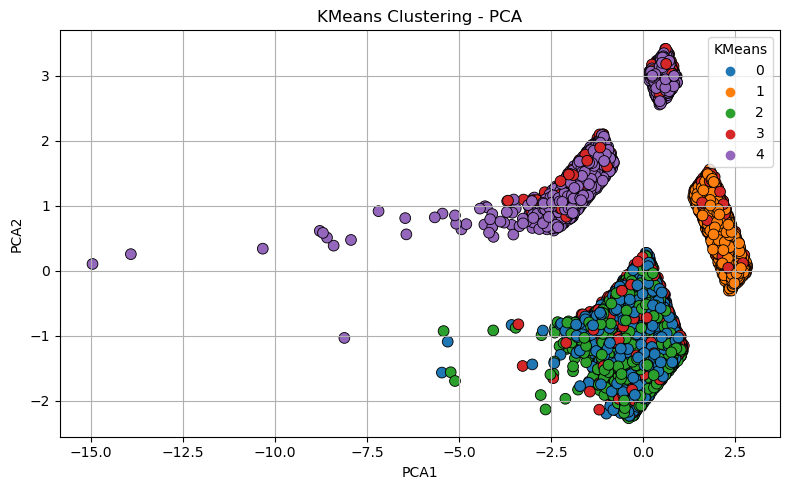

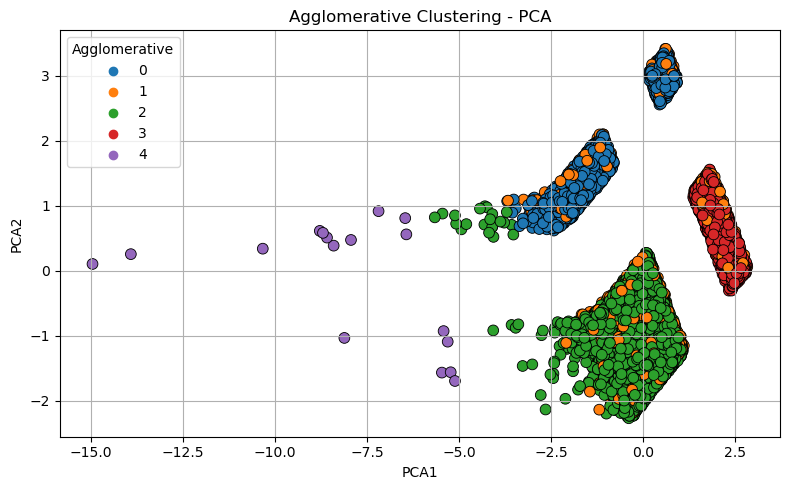

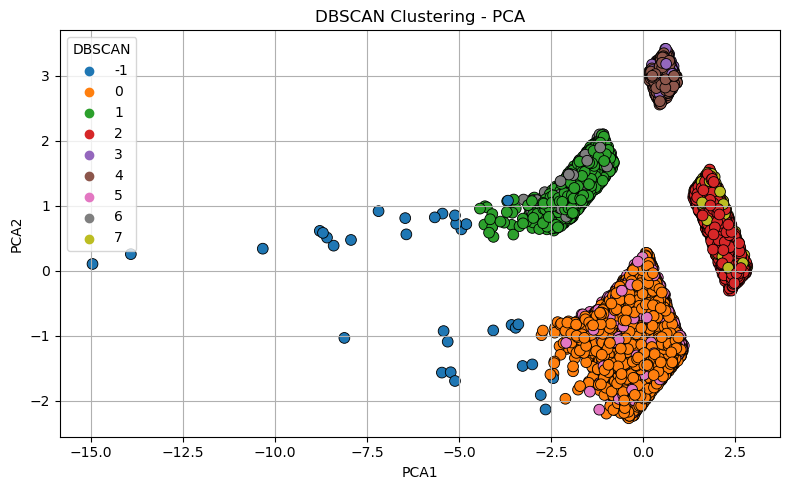

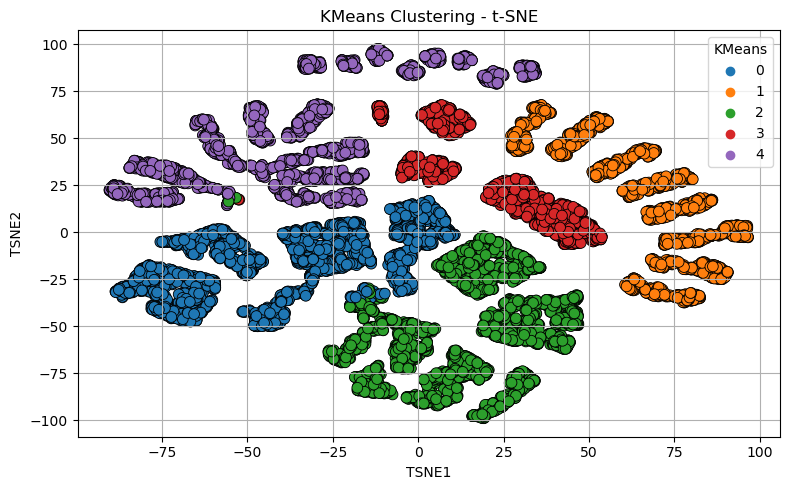

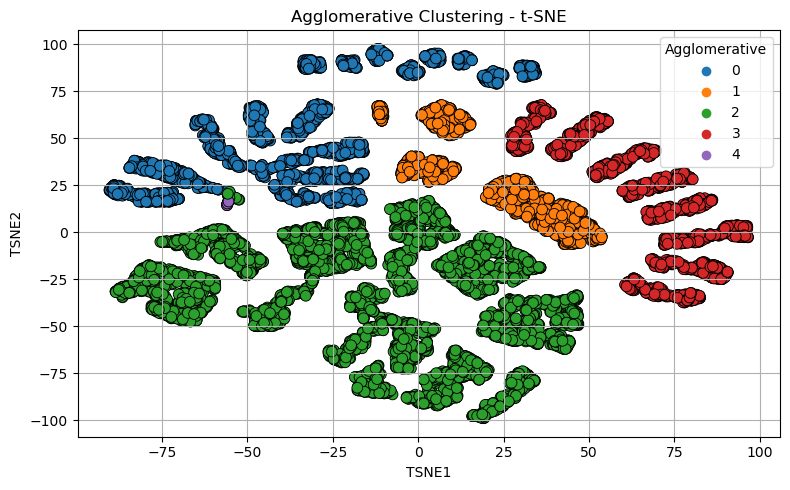

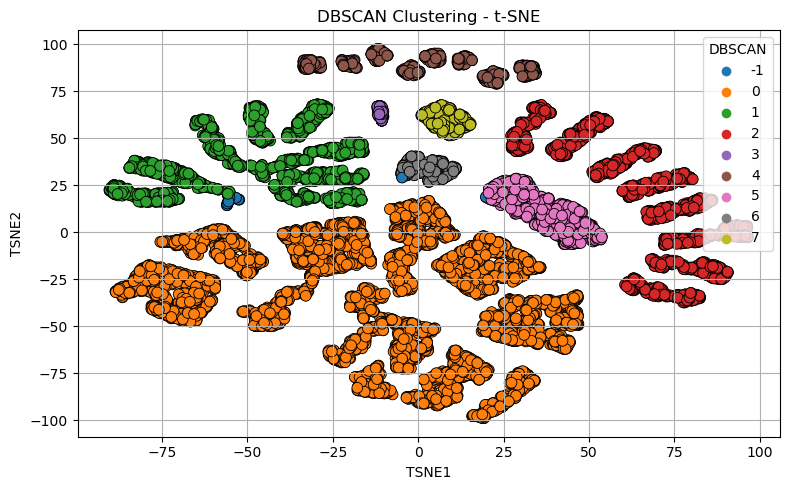

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

df = pd.read_csv("data/clean_data.csv")
df_fe2 = df.copy()

if 'Currency' in df_fe2.columns:
    df_fe2['Is_USD'] = (df_fe2['Currency'] == 'USD').astype(int)

branch_cols = [col for col in df_fe2.columns if col.startswith('Branch_') and col != 'Branch_Size']
branch_freqs = df_fe2[branch_cols].sum() / len(df_fe2)

def assign_branch_weight(row):
    for branch in branch_cols:
        if row[branch] == 1:
            return branch_freqs[branch]
    return 0.0

df_fe2['Branch_Frequency_Weight'] = df_fe2.apply(assign_branch_weight, axis=1)

transaction_cols = [col for col in df_fe2.columns if col.startswith('Account_Transaction_')]
weights = [round(i, 2) for i in np.linspace(0.14, 1.0, len(transaction_cols))]

for col, weight in zip(transaction_cols, weights):
    df_fe2[col] = df_fe2[col] * weight

df_fe2['Account_Transaction_Encoded'] = df_fe2[transaction_cols].sum(axis=1)
df_fe2 = df_fe2.drop(columns=transaction_cols)

df_fe2 = df_fe2.drop(columns=[col for col in df_fe2.columns if (col.startswith('Branch_') and col != 'Branch_Frequency_Weight') or col.startswith('Currency_')])
if 'Branch_Size' in df_fe2.columns:
    df_fe2 = df_fe2.drop(columns='Branch_Size')
for col in ['Branch', 'Currency']:
    if col in df_fe2.columns:
        df_fe2 = df_fe2.drop(columns=col)

X = scaler.fit_transform(df_fe2)

results = {}

kmeans = KMeans(n_clusters=5, random_state=42)
y_kmeans = kmeans.fit_predict(X)
results['KMeans'] = {
    'labels': y_kmeans,
    'silhouette': silhouette_score(X, y_kmeans),
    'davies_bouldin': davies_bouldin_score(X, y_kmeans)
}
df_fe2['KMeans'] = y_kmeans

agg = AgglomerativeClustering(n_clusters=5)
y_agg = agg.fit_predict(X)
results['Agglomerative'] = {
    'labels': y_agg,
    'silhouette': silhouette_score(X, y_agg),
    'davies_bouldin': davies_bouldin_score(X, y_agg)
}
df_fe2['Agglomerative'] = y_agg

dbscan = DBSCAN(eps=1.5, min_samples=5)
y_dbscan = dbscan.fit_predict(X)
df_fe2['DBSCAN'] = y_dbscan
mask = y_dbscan != -1
if len(set(y_dbscan)) > 1 and mask.sum() > 0:
    results['DBSCAN'] = {
        'labels': y_dbscan,
        'silhouette': silhouette_score(X[mask], y_dbscan[mask]),
        'davies_bouldin': davies_bouldin_score(X[mask], y_dbscan[mask])
    }
else:
    results['DBSCAN'] = {'labels': y_dbscan, 'silhouette': None, 'davies_bouldin': None}

for method, metrics in results.items():
    print(f"\n=== {method} ===")
    print(f"Silhouette Score: {metrics['silhouette']}")
    print(f"Davies-Bouldin Score: {metrics['davies_bouldin']}")

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
df_fe2['PCA1'] = X_pca[:, 0]
df_fe2['PCA2'] = X_pca[:, 1]

for method in results.keys():
    plt.figure(figsize=(8, 5))
    plt.title(f"{method} Clustering - PCA")
    sns.scatterplot(data=df_fe2, x='PCA1', y='PCA2', hue=method, palette='tab10', s=60, edgecolor='black')
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_tsne = tsne.fit_transform(X)
df_fe2['TSNE1'] = X_tsne[:, 0]
df_fe2['TSNE2'] = X_tsne[:, 1]

for method in results.keys():
    plt.figure(figsize=(8, 5))
    plt.title(f"{method} Clustering - t-SNE")
    sns.scatterplot(data=df_fe2, x='TSNE1', y='TSNE2', hue=method, palette='tab10', s=60, edgecolor='black')
    plt.xlabel("TSNE1")
    plt.ylabel("TSNE2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
